In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import time
import numpy as np

from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from local_logger import Logger
import blundell

from matplotlib import pyplot as plt

In [97]:
# use GPU for computation if possible
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [98]:
def nonlinear_function(x, noise):
    return (x + 0.3*np.sin(2*np.pi*(x + noise))
            + 0.3*np.sin(4*np.pi*(x + noise)) + noise)

# Load a dataset
def get_train_loader(size, batch_size, seed=1):
    random_gen = np.random.default_rng(seed=seed)
    train_data = random_gen.uniform(0, 0.5, size=size)
    noise = random_gen.normal(0, 0.02, size=size)
    train_targets = nonlinear_function(train_data, noise)
    # noise = random_gen.normal(0, 0.02, size=size)
    # train_targets = train_data + 0.3*np.sin(2*np.pi*(train_data+noise)) + 0.3*np.sin(4*np.pi*(train_data+noise)) + noise
    train_dataset = TensorDataset(torch.Tensor(train_data), torch.Tensor(train_targets))
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    return train_loader

def get_test_data(size, seed=1):
    test_data = np.linspace(-0.2, 1., size)
    random_gen = np.random.default_rng(seed=seed) 
    noise = random_gen.normal(0, 0.02, size=size)
    test_targets = nonlinear_function(test_data, noise)
    return torch.Tensor(test_data), torch.Tensor(test_targets)

In [99]:
# Structure for 1-d curve fitting
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = blundell.Linear(1, 16)
        self.fc2 = blundell.Linear(16,  16)
        self.fc3 = blundell.Linear(16, 16)
        self.fc4 = blundell.Linear(16,  1)

    def forward(self, x):
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [100]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.95)

train_loader = get_train_loader(size=2000, batch_size=200)
loss_function = blundell.Loss(model, train_size=len(train_loader.dataset), problem='regression').to(DEVICE)

fmt = {'tr_los': '.3e', 'te_loss': '.3e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
logger = Logger('1-d curve fitting', fmt=fmt)

In [101]:
epochs = 600

for epoch in range(1, epochs + 1):
    start = time.time()
    model.train()
    train_loss, train_acc = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(DEVICE)
        target = target.to(DEVICE).view(-1, 1)
        optimizer.zero_grad()

        # output = model(data)
        loss = loss_function(data, target)
        loss.backward()
        optimizer.step()

        train_loss += loss

    logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))

    model.eval()
    test_loss, test_acc = 0, 0
    test_data, test_target = get_test_data(size=100)
    test_data = data.to(DEVICE)
    test_target = target.to(DEVICE).view(-1, 1)
    # output = model(test_data)
    test_loss = float(loss_function(test_data, test_target))

    logger.add_scalar(epoch, 'te_loss', test_loss / len(test_data))

    for i, c in enumerate(model.children()):
        if hasattr(c, 'kl_reg'):
            logger.add_scalar(epoch, 'kl_reg_%s' % i, c.kl_reg())

    end = time.time()
    logger.add_scalar(epoch, 'time', end - start)

    if epoch % 10 == 0:
        logger.iter_info()

  epoch     tr_los    te_loss    kl_reg_0    kl_reg_1    kl_reg_2    kl_reg_3    time
-------  ---------  ---------  ----------  ----------  ----------  ----------  ------
     10  6.174e+00  6.066e+00        66.1       537.2       555.2        28.5     0.1
     20  6.099e+00  6.149e+00        70.9       544.7       556.5        33.0     0.1
     30  5.897e+00  5.847e+00        63.0       529.2       525.7        27.2     0.1
     40  5.767e+00  5.749e+00        57.6       513.2       520.5        37.3     0.1
     50  5.652e+00  5.774e+00        55.5       525.0       514.7        35.2     0.1
     60  5.581e+00  5.464e+00        61.6       480.3       511.6        27.5     0.1
     70  5.540e+00  5.576e+00        57.3       506.5       513.0        27.9     0.1
     80  5.534e+00  5.390e+00        56.5       492.8       491.1        26.3     0.1
     90  5.560e+00  5.616e+00        65.4       517.4       505.2        29.2     0.1
    100  5.601e+00  5.336e+00        53.0       476.2 

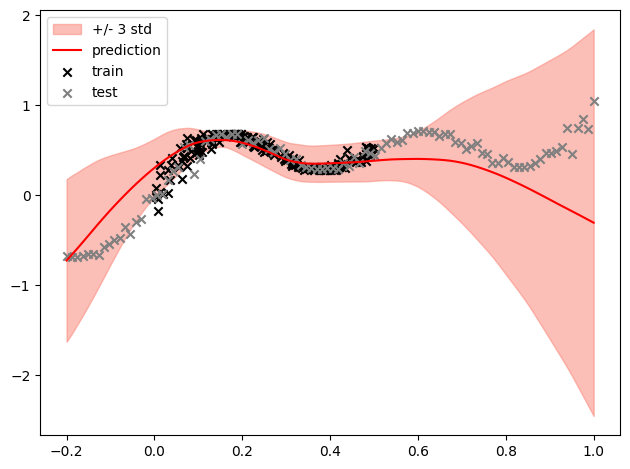

In [102]:
num_samples = 50

# train_data, train_target = train_loader.dataset.tensors
train_data, train_target = next(iter(train_loader))
test_data, test_target = get_test_data(100)

outputs = torch.zeros(num_samples, len(test_data), 1).to(DEVICE)

model.train()
for i in range(num_samples):
    outputs[i] = model(test_data)

mean = torch.mean(outputs, axis=0).detach().numpy().squeeze(1)
std = torch.std(outputs, axis=0).detach().numpy().squeeze(1) 
# median = torch.median(outputs, axis=0).values.detach().numpy().squeeze(1)
# quant_25 = torch.quantile(outputs, 0.25, axis=0).detach().numpy().squeeze(1) 
# quant_75 = torch.quantile(outputs, 0.75, axis=0).detach().numpy().squeeze(1) 


# Visualization

# plt.fill_between(
#     test_data, 
#     quant_25, quant_75,
#     color='cornflowerblue', alpha=.5, label='quantiles')

plt.fill_between(
    test_data, 
    mean - 3*std, mean + 3*std,
    color='salmon', alpha=.5, label='+/- 3 std')

# plt.plot(test_data, median, c='red', label='prediction')
plt.plot(test_data, mean, c='red', label='prediction')
plt.scatter(train_data, train_target, marker='x', c='black', label='train')
plt.scatter(test_data, test_target, c='grey', label='test', marker='x')
plt.legend()
plt.tight_layout()